# Wielowymiarowe prognozowanie szeregów czasowych

In [73]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.var_model import VAR

In [74]:
stocks_data = pd.read_csv('stocks.csv')
stocks_data.head()

,Ticker,Date,Open,High,Low,Close,Adj Close,Volume
0,AAPL,2023-02-07,150.639999,155.229996,150.639999,154.649994,154.414230,83322600
1,AAPL,2023-02-08,153.880005,154.580002,151.169998,151.919998,151.688400,64120100
2,AAPL,2023-02-09,153.779999,154.330002,150.419998,150.869995,150.639999,56007100
3,AAPL,2023-02-10,149.460007,151.339996,149.220001,151.009995,151.009995,57450700
4,AAPL,2023-02-13,150.949997,154.259995,150.919998,153.850006,153.850006,62199000


Sprawdź, czy w zestawie danych nie ma brakujących wartości.  
Przekonwertuj kolumnę Date na typ data/godzina na potrzeby analizy szeregów czasowych.  
Sprawdź, ile unikalnych akcji (tickerów) jest obecnych i jakie są ich odpowiednie punkty danych.  

In [75]:
stocks_data['Date'] = pd.to_datetime(stocks_data['Date'])
missing_values = stocks_data.isnull().sum()
unique_stocks = stocks_data['Ticker'].value_counts()
print(missing_values)

Ticker       0
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [76]:
print(unique_stocks)

Ticker
AAPL    62
MSFT    62
NFLX    62
GOOG    62
Name: count, dtype: int64


Zakres czasowy zbioru danych.

In [77]:
time_range = stocks_data['Date'].min(), stocks_data['Date'].max()
print(time_range)

(Timestamp('2023-02-07 00:00:00'), Timestamp('2023-05-05 00:00:00'))


Trendy cen najwyższych (high) i najniższych (low) dla każdej akcji.

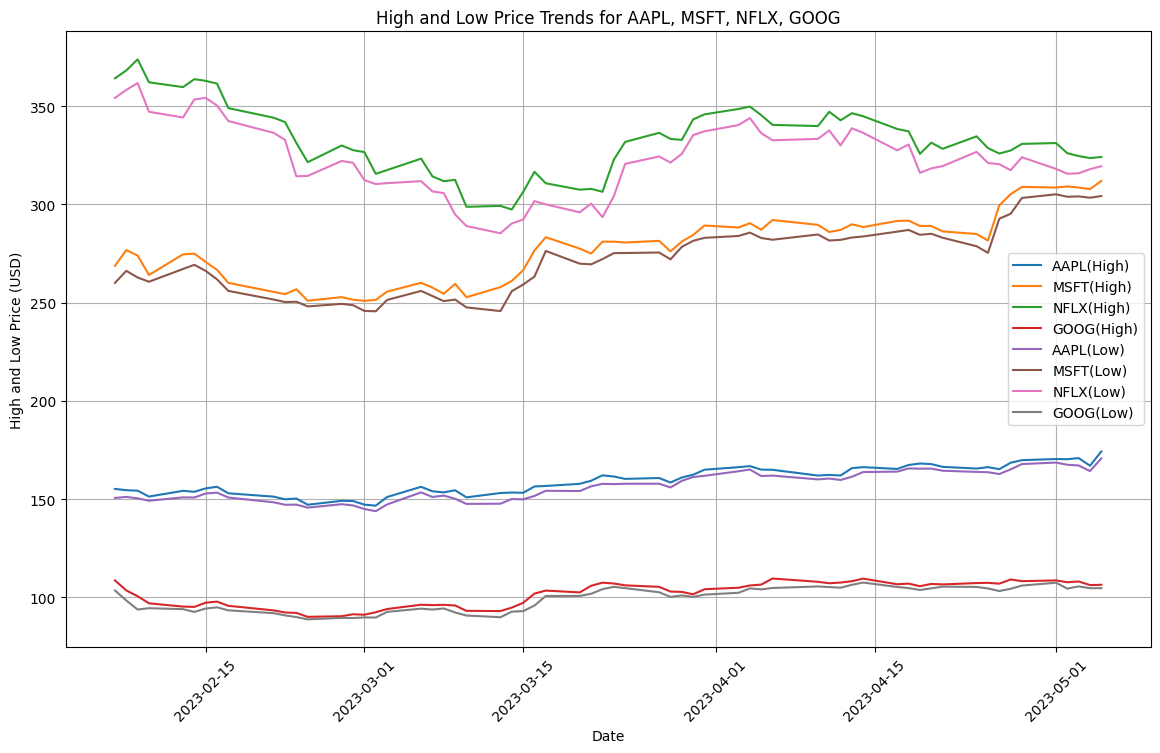

In [78]:
fix, ax = plt.subplots(figsize=(14, 8))

for ticker in unique_stocks.index:
    subset = stocks_data[stocks_data['Ticker'] == ticker]
    ax.plot(subset['Date'], subset['High'], label=f'{ticker}(High)')

for ticker in unique_stocks.index:
    subset = stocks_data[stocks_data['Ticker'] == ticker]
    ax.plot(subset['Date'], subset['Low'], label=f'{ticker}(Low)')

ax.set_title('High and Low Price Trends for AAPL, MSFT, NFLX, GOOG')
ax.set_xlabel('Date')
ax.set_ylabel('High and Low Price (USD)')
ax.legend()

plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Wybór modelu i przygotowanie danych

Test ADF na stacjonarność

In [79]:
def adf_test(series, title=''):
    print(f'ADF Test on "{title}"')
    result = adfuller(series, autolag='AIC')
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    out = pd.Series(result[0:4], index=labels)
    
    for key, value in result[4].items():
        out[f'Critical Value ({key})'] = value
    print(out.to_string(), '\n')

for ticker in unique_stocks.index:
    series = stocks_data[stocks_data['Ticker'] == ticker]['High']
    adf_test(series, title=f'{ticker}(High)')

for ticker in unique_stocks.index:
    series = stocks_data[stocks_data['Ticker'] == ticker]['Low']
    adf_test(series, title=f'{ticker}(Low)')

ADF Test on "AAPL(High)"
ADF Test Statistic             -0.329619
p-value                         0.921203
#Lags Used                      0.000000
Number of Observations Used    61.000000
Critical Value (1%)            -3.542413
Critical Value (5%)            -2.910236
Critical Value (10%)           -2.592745 

ADF Test on "MSFT(High)"
ADF Test Statistic             -0.225638
p-value                         0.935396
#Lags Used                      0.000000
Number of Observations Used    61.000000
Critical Value (1%)            -3.542413
Critical Value (5%)            -2.910236
Critical Value (10%)           -2.592745 

ADF Test on "NFLX(High)"
ADF Test Statistic             -3.740842
p-value                         0.003574
#Lags Used                      8.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796 

ADF Test on "GOOG(High)"
ADF Test Statistic             -1

Uczyńmy szereg stacjonarnym poprzez różnicowanie cen i ponowne testowanie stacjonarności:

In [80]:
stocks_data['Diff_High'] = stocks_data.groupby('Ticker')['High'].transform(lambda x: x.diff())

for ticker in unique_stocks.index:
    series = stocks_data[stocks_data['Ticker'] == ticker]['Diff_High'].dropna()
    adf_test(series, title=f'{ticker}(High) - Differenced')

stocks_data['Diff_Low'] = stocks_data.groupby('Ticker')['Low'].transform(lambda x: x.diff())

for ticker in unique_stocks.index:
    series = stocks_data[stocks_data['Ticker'] == ticker]['Diff_Low'].dropna()
    adf_test(series, title=f'{ticker}(Low) - Differenced')

ADF Test on "AAPL(High) - Differenced"
ADF Test Statistic            -8.115163e+00
p-value                        1.196414e-12
#Lags Used                     0.000000e+00
Number of Observations Used    6.000000e+01
Critical Value (1%)           -3.544369e+00
Critical Value (5%)           -2.911073e+00
Critical Value (10%)          -2.593190e+00 

ADF Test on "MSFT(High) - Differenced"
ADF Test Statistic            -7.715953e+00
p-value                        1.228170e-11
#Lags Used                     0.000000e+00
Number of Observations Used    6.000000e+01
Critical Value (1%)           -3.544369e+00
Critical Value (5%)           -2.911073e+00
Critical Value (10%)          -2.593190e+00 

ADF Test on "NFLX(High) - Differenced"
ADF Test Statistic            -7.304201e+00
p-value                        1.314509e-10
#Lags Used                     0.000000e+00
Number of Observations Used    6.000000e+01
Critical Value (1%)           -3.544369e+00
Critical Value (5%)           -2.911073e+00

### Szkolenie modelowe

Trenowanie modelu VAR na całym zbiorze danych, najpierw dla cen najwyższych (high)

In [81]:
var_data = stocks_data.pivot(index='Date', columns='Ticker', values='Diff_High').dropna()
model = VAR(var_data)
model_fitted = model.fit(ic='aic')

forecast_steps = 5
forecasted_values = model_fitted.forecast(var_data.values[-model_fitted.k_ar:], steps=forecast_steps)
forecasted_df = pd.DataFrame(forecasted_values, index=pd.date_range(start=var_data.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D'), columns=var_data.columns)

for column in forecasted_df.columns:
    forecasted_df[column] = (stocks_data.groupby('Ticker')['High'].last()[column] + forecasted_df[column].cumsum())

print(forecasted_df)

Ticker            AAPL        GOOG        MSFT        NFLX
2023-05-06  168.321095  104.456980  307.683002  313.988287
2023-05-07  178.141177  105.995563  319.320397  324.550555
2023-05-08  171.556669  109.583864  326.963737  330.620974
2023-05-09  173.257870  107.278297  330.314859  326.122673
2023-05-10  166.958016  106.825572  324.039376  335.606323


C:\Users\Arek\PycharmProjects\Statistics-Algebra\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Historyczne ceny najwyższe (high) wraz z prognozowanymi cenami dla każdej akcji na jednym wykresie

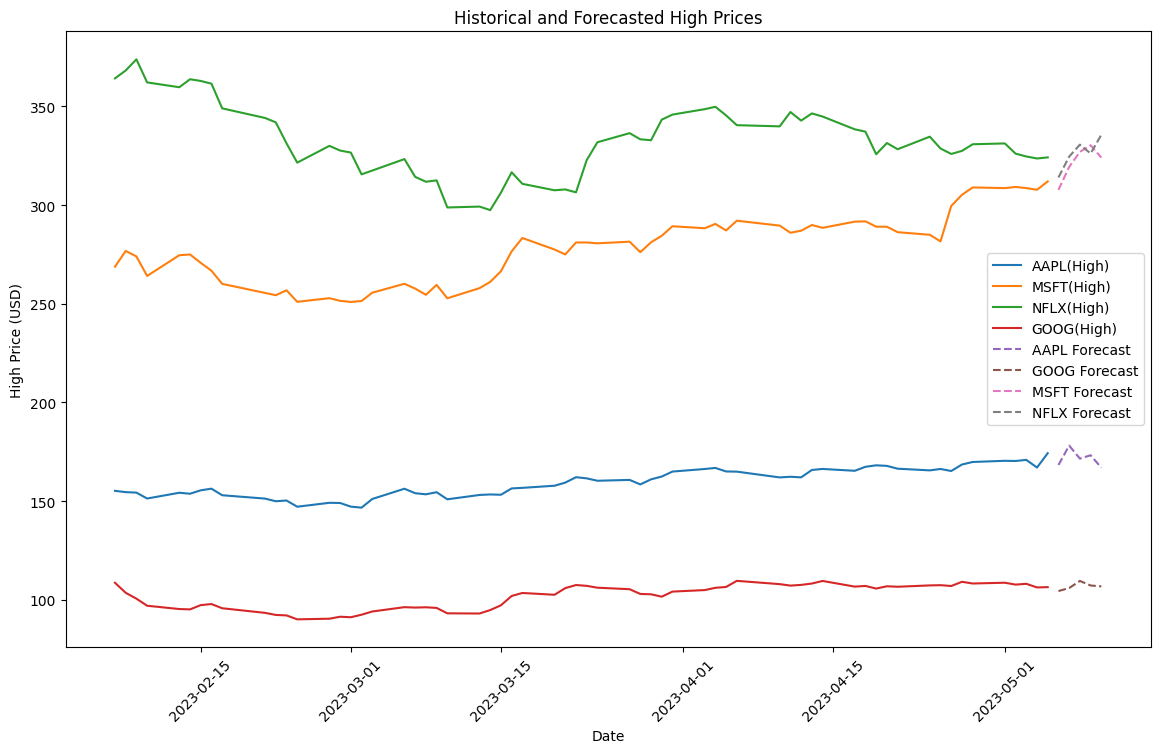

In [82]:
fix, ax = plt.subplots(figsize=(14, 8))

for ticker in unique_stocks.index:
    historical_data = stocks_data[stocks_data['Ticker'] == ticker]
    ax.plot(historical_data['Date'], historical_data['High'], label=f'{ticker}(High)')

for column in forecasted_df.columns:
    ax.plot(forecasted_df.index, forecasted_df[column], label=f'{column} Forecast', linestyle='--')

ax.set_title('Historical and Forecasted High Prices')
ax.set_xlabel('Date')
ax.set_ylabel('High Price (USD)')
ax.legend()

plt.xticks(rotation=45)
plt.show()

Trenowanie modelu VAR na całym zbiorze danych dla cen najniższych (low)

In [83]:
var_data = stocks_data.pivot(index='Date', columns='Ticker', values='Diff_Low').dropna()
model = VAR(var_data)
model_fitted = model.fit(ic='aic')

forecast_steps = 5
forecasted_values = model_fitted.forecast(var_data.values[-model_fitted.k_ar:], steps=forecast_steps)
forecasted_df = pd.DataFrame(forecasted_values, index=pd.date_range(start=var_data.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D'), columns=var_data.columns)

for column in forecasted_df.columns:
    forecasted_df[column] = (stocks_data.groupby('Ticker')['Low'].last()[column] + forecasted_df[column].cumsum())

print(forecasted_df)

Ticker            AAPL        GOOG        MSFT        NFLX
2023-05-06  175.080171  110.691201  321.291749  323.790331
2023-05-07  174.559842  109.866745  333.096850  341.561253
2023-05-08  173.327942  102.157180  344.377730  364.893084
2023-05-09  164.688876   91.118955  336.368599  331.793832
2023-05-10  163.039522   93.413246  325.727138  336.484943


C:\Users\Arek\PycharmProjects\Statistics-Algebra\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Historyczne ceny najniższe (low) wraz z prognozowanymi cenami dla każdej akcji na jednym wykresie

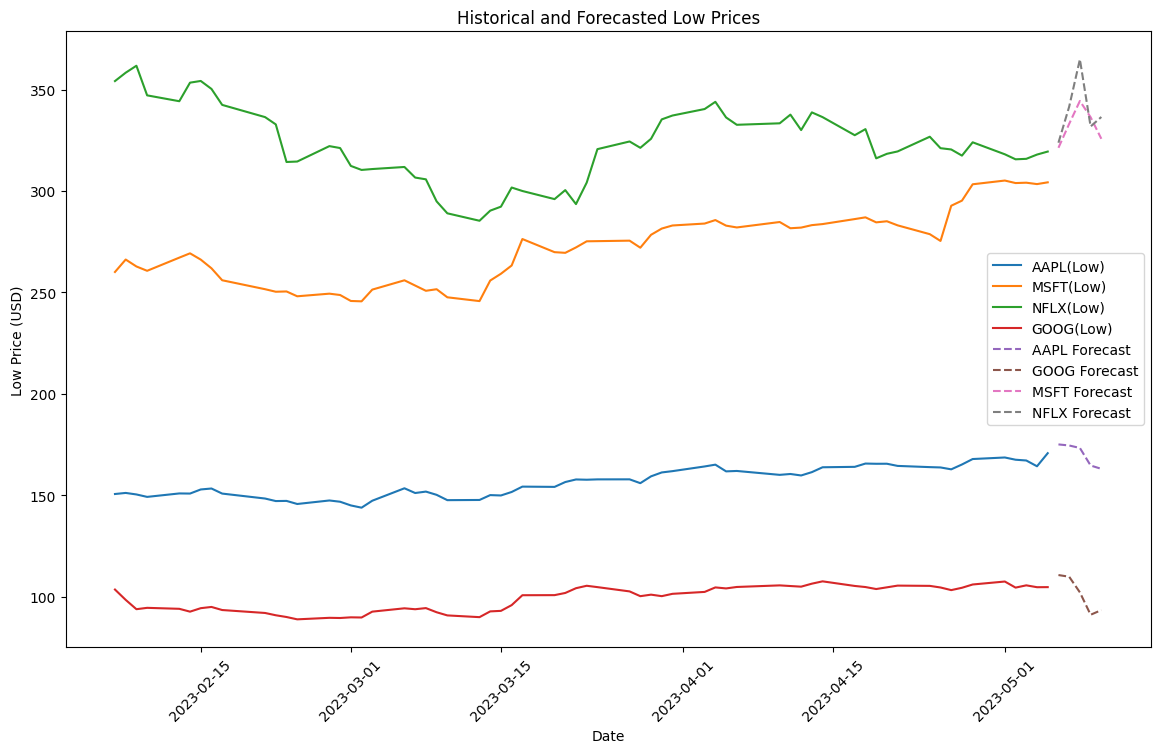

In [84]:
fix, ax = plt.subplots(figsize=(14, 8))

for ticker in unique_stocks.index:
    historical_data = stocks_data[stocks_data['Ticker'] == ticker]
    ax.plot(historical_data['Date'], historical_data['Low'], label=f'{ticker}(Low)')

for column in forecasted_df.columns:
    ax.plot(forecasted_df.index, forecasted_df[column], label=f'{column} Forecast', linestyle='--')

ax.set_title('Historical and Forecasted Low Prices')
ax.set_xlabel('Date')
ax.set_ylabel('Low Price (USD)')
ax.legend()

plt.xticks(rotation=45)
plt.show()